In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loaded 1000 images. Polyp: 1000, Non-Polyp: 0
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 606s 12s/step - accuracy: 1.0000 - loss: 0.0299 - val_accuracy: 1.0000 - val_loss: 9.3158e-05
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 638s 12s/step - accuracy: 1.0000 - loss: 1.0238e-04 - val_accuracy: 1.0000 - val_loss: 4.4349e-05
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 651s 13s/step - accuracy: 1.0000 - loss: 8.2309e-05 - val_accuracy: 1.0000 - val_loss: 2.0600e-05
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 593s 12s/step - accuracy: 1.0000 - loss: 2.9193e-05 - val_accuracy: 1.0000 - val_loss: 1.2182e-05
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 580s 12s/step - accuracy: 1.0000 - loss: 1.7672e-05 - val_accuracy: 1.0000 - val_loss: 7.8897e-06
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 594s 12s/step - accuracy: 1.0000 - loss: 1.1767e-05 - val_accuracy: 1.0000 - val_loss: 5.5348e-06
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 627s 12s/step - accuracy: 1.0000 - loss: 1.0229e-05

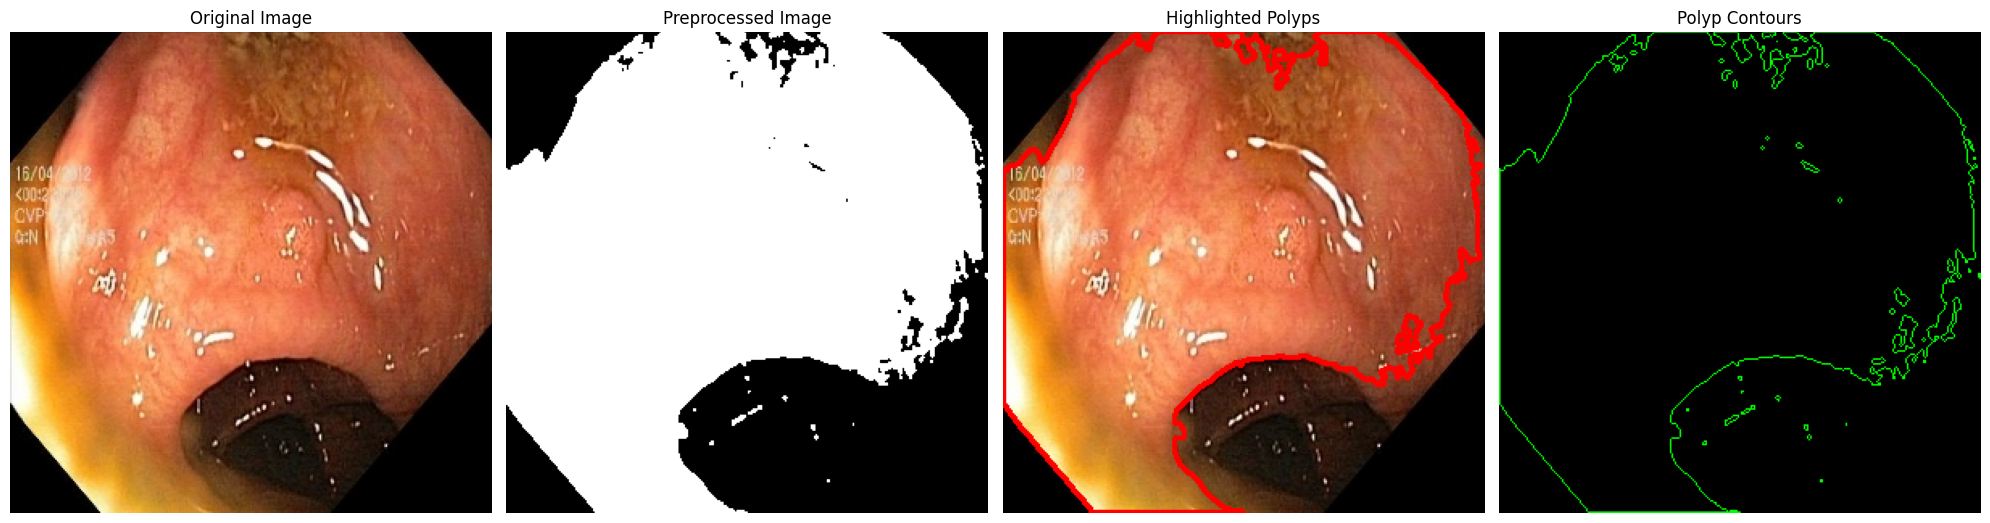

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Prediction: Polyp (100.00%)


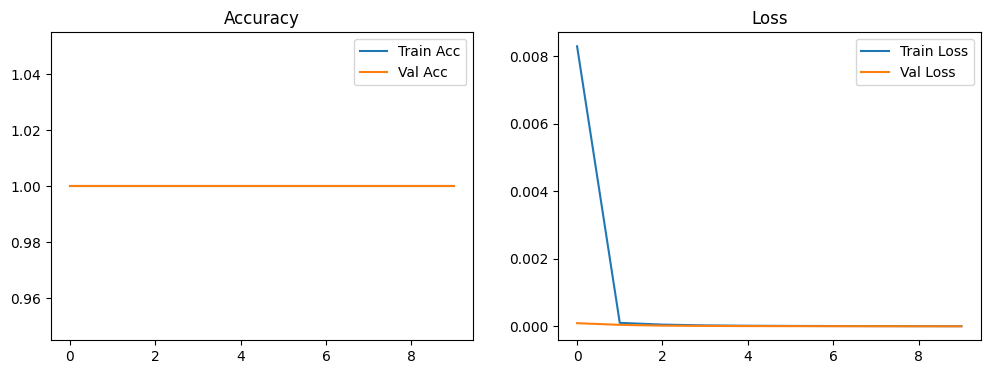

In [2]:
class PolypClassifier:
    def __init__(self, input_shape=(299, 299, 3), num_classes=2):
        base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        predictions = Dense(num_classes, activation='softmax')(x)

        self.model = Model(inputs=base_model.input, outputs=predictions)
        for layer in base_model.layers:
            layer.trainable = False

        self.model.compile(optimizer=Adam(learning_rate=1e-4),
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

    def train(self, X_train, y_train, X_val, y_val, batch_size=16, epochs=10):
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = self.model.fit(X_train, y_train,
                               validation_data=(X_val, y_val),
                               epochs=epochs,
                               batch_size=batch_size,
                               callbacks=[early_stop])
        return history

    def predict(self, img):
        img = cv2.resize(img, (299, 299))
        img = img.astype('float32') / 255.0
        pred = self.model.predict(np.expand_dims(img, axis=0))
        return np.argmax(pred), np.max(pred)

    def detect_and_visualize_polyps(self, img_path):
        # Load and preprocess image
        original_img = cv2.imread(img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        # Preprocessing steps
        gray = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        _, threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Find contours
        contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Create highlighted image (red polyps)
        highlighted = original_img.copy()
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 100:  # Filter small contours
                cv2.drawContours(highlighted, [contour], -1, (255, 0, 0), 2)

        # Create contour visualization
        contour_img = np.zeros_like(original_img)
        cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 1)

        # Display results
        display_results(original_img,
                       cv2.cvtColor(threshold, cv2.COLOR_GRAY2RGB),
                       highlighted,
                       contour_img)

        # Classify using the model
        class_idx, confidence = self.predict(original_img)
        class_names = ['Non-Polyp', 'Polyp']
        return class_names[class_idx], confidence

def display_results(original, preprocessed, highlighted, contour_img):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 4, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(preprocessed)
    plt.title("Preprocessed Image")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(highlighted)
    plt.title("Highlighted Polyps")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(contour_img)
    plt.title("Polyp Contours")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def load_dataset_from_kvasir(images_path, masks_path):
    data, labels = [], []
    for fname in os.listdir(images_path):
        img_path = os.path.join(images_path, fname)
        mask_path = os.path.join(masks_path, fname)

        if not os.path.exists(mask_path):
            continue

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is not None and mask is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (299, 299))
            mask = cv2.resize(mask, (299, 299))

            label = 1 if np.any(mask > 10) else 0  # 1=polyp, 0=non-polyp
            data.append(img)
            labels.append(label)

    return np.array(data), np.array(labels)

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    images_path = '/content/drive/MyDrive/Kvasir-SEG/images'
    masks_path = '/content/drive/MyDrive/Kvasir-SEG/masks'

    X, y = load_dataset_from_kvasir(images_path, masks_path)
    X = X.astype('float32') / 255.0

    print(f"Loaded {len(X)} images. Polyp: {np.sum(y)}, Non-Polyp: {len(y) - np.sum(y)}")

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    classifier = PolypClassifier()
    history = classifier.train(X_train, y_train, X_val, y_val)

    val_loss, val_acc = classifier.model.evaluate(X_val, y_val)
    print(f"Validation Accuracy: {val_acc * 100:.2f}%")

    # Example usage of the visualization with polyp detection
    test_img_path = '/content/drive/MyDrive/Kvasir-SEG/images/cju0qkw35aoqj0993l4e2j12o.jpg'  # Replace with actual path
    if os.path.exists(test_img_path):
        pred_class, confidence = classifier.detect_and_visualize_polyps(test_img_path)
        print(f"Prediction: {pred_class} ({confidence*100:.2f}%)")
    else:
        print("Test image not found, using first validation image instead")
        test_img = X_val[0]
        test_img = (test_img * 255).astype('uint8')  # Convert back to 0-255 range
        cv2.imwrite('/content/temp_test_img.jpg', cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR))
        pred_class, confidence = classifier.detect_and_visualize_polyps('/content/temp_test_img.jpg')
        print(f"Prediction: {pred_class} ({confidence*100:.2f}%)")

    plot_training_history(history)